<a href="https://colab.research.google.com/github/CamilleGreen5/Deep_Learning_with_Python/blob/master/Noise_speech_reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INFO :
- methode des masks donnent mauvais résultats (avec label)

## **DATA LOADING**

In [ ]:
# !pip install pydub

In [ ]:
# !wget https://voice-prod-bundler-ee1969a6ce8178826482b88e843c335139bd3fb4.s3.amazonaws.com/cv-corpus-5.1-2020-06-22/fr.tar.gz

In [3]:
# !tar -xf fr.tar.gz

In [4]:
!rm fr.tar.gz
!rm -r sample_data

!mkdir sons
!mkdir sons/original
!mkdir sons/noisy
!mkdir sons/denoised

!mkdir data
!mkdir data/train_data
!mkdir data/val_data
!mkdir data/test_data
!mkdir data/train_data/folder1
!mkdir data/val_data/folder1
!mkdir data/test_data/folder1

!cp cv-corpus-5.1-2020-06-22/fr/clips/common_voice_fr_18157595.mp3 ./sons/original

## **FUNCTIONS AND LIBRARIES LOAD**

In [5]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard

In [6]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import glob
import datetime
import os
import cv2 as cv
from scipy.io.wavfile import read, write
from scipy.signal import stft, istft
from pydub import AudioSegment
from tensorflow.keras import models, layers
from tqdm.notebook import tqdm

## **DATA CONVERSION**

In [47]:
def add_noise(array_sound):
          
    max_1 = np.max(array_sound)
    noise = np.random.normal(0, 0.02*max_1, len(array_sound))
    array_sound_noisy = np.add(noise, array_sound)
    max_2 = np.max(array_sound_noisy)
    array_sound_noisy = (array_sound_noisy*max_1)//max_2

    return np.array(array_sound_noisy, np.int16)

In [48]:
def load_and_convert_data_with_label(train_mp3_data, mode='train'):

    i = 0

    for path_to_mp3_file in tqdm(train_mp3_data):

        # load mp3 sound to array
        loaded_sound = AudioSegment.from_mp3(path_to_mp3_file)
        array_sound = np.array(loaded_sound.get_array_of_samples(), np.int16)
        # print(np.max(np.max(array_sound)))
        
        # normalize array
        mean = np.mean(array_sound, axis=0)
        array_sound -= int(mean)

        # convert label to to F_T_space
        f, t, array_stft = stft(array_sound, fs=48000, nperseg=1000)
        original_abs_stft = np.abs(array_stft[:,:1000])

        # padding
        pad_length = 1000 - np.shape(original_abs_stft)[1]
        # print(pad_length)
        original_abs_stft = np.pad(original_abs_stft, ((0,0), (0, pad_length)))
        # print(np.shape(original_abs_stft))
        
        # add random noise
        array_sound_noisy = add_noise(array_sound)

        # plot original and noisy
        # plt.plot([i for i in range(len(array_sound_noisy))], array_sound_noisy, 'r')
        # plt.plot([i for i in range(len(array_sound))], array_sound, 'b')
        # plt.show()

        # save noisy sound to wav
        # path_to_wav_file = './sons/noisy/noisy_sound0.wav'
        # write(path_to_wav_file, 48000, array_sound_noisy)

        # convert sample to to F_T_space
        f, t, array_stft = stft(array_sound_noisy, fs=48000, nperseg=1000)
        sample_abs_stft = np.abs(array_stft[:,:1000])

        # padding 
        pad_length = 1000 - np.shape(sample_abs_stft)[1]
        sample_abs_stft = np.pad(sample_abs_stft, ((0,0), (0, pad_length)))
        # print(np.shape(sample_abs_stft))

        # convertion to image format
        sample_to_save = sample_abs_stft//(np.max(np.max(sample_abs_stft))/32767)
        label_to_save = original_abs_stft//(np.max(np.max(original_abs_stft))/32767)
        sample_to_save0 = sample_to_save - sample_to_save%1000
        sample_to_save1 = sample_to_save - sample_to_save0 - sample_to_save%10
        label_to_save0 = label_to_save - label_to_save%1000
        label_to_save1 = label_to_save - label_to_save0 - label_to_save%10
        sample_label_to_save = np.stack((sample_to_save0, sample_to_save1, label_to_save0, label_to_save1), axis=2)
        sample_label_to_save = np.array(sample_label_to_save, np.int16)
        # print(np.shape(sample_label_to_save))

        # saving images
        if mode == 'train':
            path_sample = str("./data/train_data/folder1/sample" + str(i) + ".png")
        elif mode == 'val':
            path_sample = str("./data/val_data/folder1/sample" + str(i) + ".png")
        elif mode == 'test':
            path_sample = str("./data/test_data/folder1/sample" + str(i) + ".png")
        else:
            print("chose a mode")
        tf.keras.preprocessing.image.save_img(path_sample, sample_label_to_save, data_format='channels_last')

        # free space
        path = train_mp3_data[i]
        try:
            os.remove(path)
        except FileNotFoundError:
            continue

        i+=1
    

In [ ]:
# !rm data/test_data/folder1/*
# !rm data/train_data/folder1/*
# !rm data/val_data/folder1/*

In [49]:
list_mp3_files = glob.glob("./cv-corpus-5.1-2020-06-22/fr/clips/*.mp3")
print(len(list_mp3_files))

train_mp3_data = list_mp3_files[:1000]
val_mp3_data = list_mp3_files[1000:1250]
# test_mp3_data = list_mp3_files[7000:14000]

450077


In [50]:
load_and_convert_data_with_label(train_mp3_data, 'train')
load_and_convert_data_with_label(val_mp3_data, 'val')
# load_and_convert_data_with_label(test_mp3_data, 'test')

In [ ]:
!ls data/train_data/folder1 | wc -l

5000


## **MODEL FITING**

In [ ]:
# !rm -r logs/fit/*

In [60]:
def build_model():

    model = models.Sequential()
    model.add(layers.Conv1D(501, 10, activation='relu', padding='same', input_shape=(1000, 501)))
    # model.add(layers.MaxPool1D(2, padding='same'))
    model.add(layers.Conv1D(501, 10, activation='relu', padding='same'))
    # model.add(layers.MaxPool1D(2, padding='same'))
    model.add(layers.LSTM(501, return_sequences=True))
    # model.add(layers.UpSampling1D(4))

    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

    return model

In [100]:
def data_generator(mode='train'):

    img_gen = tf.keras.preprocessing.image.ImageDataGenerator()
    if mode == 'train':
        samples_and_labels = img_gen.flow_from_directory("./data/train_data/", class_mode=None, target_size=(501, 1000), batch_size=1, color_mode='rgba')
    elif mode == 'val':
        samples_and_labels = img_gen.flow_from_directory("./data/val_data/", class_mode=None, target_size=(501, 1000), batch_size=1, color_mode='rgba')
    elif mode == 'test':
        samples_and_labels = img_gen.flow_from_directory("./data/test_data/", class_mode=None, target_size=(501, 1000), batch_size=1, color_mode='rgba')  
    else:
        print("chose a mode")

    batch_sample = []
    batch_label = []

    for sample_and_label in samples_and_labels:
        sample_and_label = np.array(sample_and_label, np.int16)
        # print(np.shape(sample_and_label))
        sample0 = np.squeeze(sample_and_label[:,:,:,0])
        sample1 = np.squeeze(sample_and_label[:,:,:,1])
        label0 = np.squeeze(sample_and_label[:,:,:,2])
        label1 = np.squeeze(sample_and_label[:,:,:,3])
        sample = 1000*sample0 + 10*sample1
        label = 1000*label0 + 10*label1
        max_arr = 32767
        sample = np.array(sample/max_arr, np.float32)
        label = np.array(label/max_arr, np.float32)

        sample = tf.convert_to_tensor(sample)
        label = tf.convert_to_tensor(label)

        sample = np.transpose(sample)
        label = np.transpose(label)

        # print(np.shape(sample))
        # print(np.shape(label))

        if len(batch_sample) == 5:
            yield batch_sample, batch_label
            batch_sample = []
            batch_label = []
        else:
            batch_sample.append(sample)
            batch_label.append(label)

        # yield sample, label
        
def create_train_generator():
    gen = data_generator('train')
    return gen
        
def create_val_generator():
    gen = data_generator('val')
    return gen

In [96]:
gen = create_train_generator()
label, sample = next(gen)
print(np.shape(label))


Found 1000 images belonging to 1 classes.
(1000, 501)


In [ ]:
NEW_MODEL = True
if NEW_MODEL:
    !rm -r logs/fit/*

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

if NEW_MODEL:
    model = build_model()
else:
    model = tf.keras.models.load_model("model/mymodel")


train_dataset = tf.data.Dataset.from_generator(create_train_generator, output_types=(tf.float32, tf.float32), output_shapes=((5, 1000, 501), (5, 1000, 501)))
validation_dataset = tf.data.Dataset.from_generator(create_val_generator, output_types=(tf.float32, tf.float32), output_shapes=((5, 1000, 501), (5, 1000, 501)))

# for element in dataset:
#     sample = np.array(element[0])
#     label = np.array(element[1])
#     print(np.shape(sample))
#     print(np.shape(label))
#     # saving images
#     path_sample = str("./temp/sample0.jpg")
#     sample_to_save = np.stack((sample, sample, sample))
#     tf.keras.preprocessing.image.save_img(path_sample, sample_to_save, data_format='channels_first', scale=True)

#     break

model.fit(train_dataset, epochs=50, shuffle=True, callbacks=[tensorboard_callback],\
          steps_per_epoch=1000, validation_data=validation_dataset, validation_steps=250, verbose=1)

model.save('./model/mymodel')
print('model saved')


Epoch 1/50
Found 1000 images belonging to 1 classes.
 161/1000 [===>..........................] - ETA: 9:08 - loss: 0.0015 - mae: 0.0067

## **VISUALISATION**


In [ ]:
# !kill 8599

In [ ]:
%tensorboard --logdir logs/fit --host localhost

 ## **AUDIO RECONVERSION**

In [ ]:
def reshape_data(samples, labels=None):

    shapes = np.shape(samples)

    samples = np.transpose(samples)
    if labels is not None:
        labels = np.transpose(labels)

    samples = np.reshape(samples, (1, shapes[0]*1000, 501))
    if labels is not None:
        labels = np.reshape(labels, (1, shapes[0]*1000, 501))

    samples = np.squeeze(samples)
    if labels is not None:
        labels = np.squeeze(labels)

    return samples, labels

In [ ]:
def load_and_convert_data(train_mp3_data, add_noise_to_sample=False):

    samples = []
    im_samples = []
    i = 0

    for path_to_mp3_file in tqdm(train_mp3_data):

        # load mp3 sound to array
        loaded_sound = AudioSegment.from_mp3(path_to_mp3_file)
        array_sound = np.array(loaded_sound.get_array_of_samples(), np.float64)

        len_arr = len(array_sound)

        plt.plot([i for i in range(len(array_sound))], array_sound, 'b')
        plt.show()

        # normalize array
        mean = np.mean(array_sound, axis=0)
        array_sound -= mean

        if add_noise_to_sample:
            array_sound = add_noise(array_sound)
            # save reconverted sound to wav
            path_to_wav_file = './sons/noisy/noisy_sound0.wav'
            write(path_to_wav_file, 48000, array_sound)

        max_arr = np.max(np.abs(array_sound))
        array_sound = np.array(array_sound/max_arr, np.float32)

        # convert sample to to F_T_space
        f, t, array_stft = stft(array_sound, fs=48000, nperseg=1000)
        sample_abs_stft = np.abs(array_stft)
        sample_im_stft = np.imag(array_stft)

        # padding 
        pad_length = 1000 - np.shape(sample_abs_stft)[1]
        sample_abs_stft = np.pad(sample_abs_stft, ((0,0), (0, pad_length)))
        sample_im_stft = np.pad(sample_im_stft, ((0,0), (0, pad_length)))

        samples.append(sample_abs_stft)
        im_samples.append(sample_im_stft)
        i+=1

    samples = np.array(samples)
    im_samples = np.array(im_samples)

    return samples, im_samples, mean, max_arr, len_arr

In [ ]:
def denoising(samples, imag_samples, mean, max_arr, len_arr):
    
    # load model
    model = tf.keras.models.load_model('./model/mymodel')

    # predict
    samples, x = reshape_data(samples)
    imag_samples, x = reshape_data(imag_samples)
    # print(np.shape(samples), np.shape(imag_samples))

    denoised_samples = model.predict(samples)
    
    denoised_samples = np.transpose(denoised_samples)
    imag_samples = np.transpose(imag_samples)

    # print(np.shape(denoised_samples))

    # plt.pcolormesh(denoised_samples[:len_arr,:])
    # plt.title('STFT denoised Magnitude')
    # plt.ylabel('Frequency [Hz]')
    # plt.xlabel('Time [sec]')
    # plt.show()

    # print(np.shape(denoised_samples))
    denoised_stft = denoised_samples + 1j*imag_samples

    # convert back to sound from F_T_space
    t, desnoised_array_sound = istft(denoised_stft, fs=48000, nperseg=1000)
    desnoised_array_sound = np.array(desnoised_array_sound)
    desnoised_array_sound *= max_arr
    desnoised_array_sound += mean
    desnoised_array_sound = np.array(desnoised_array_sound, np.int16)

    return desnoised_array_sound


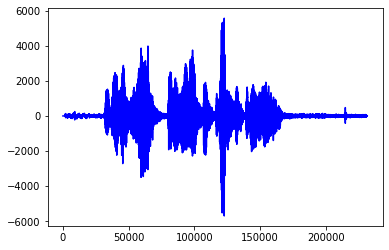

5715



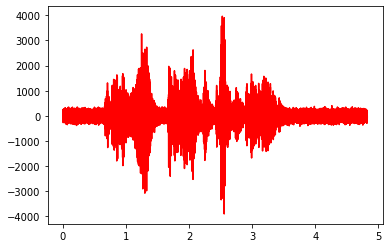

In [ ]:
list_files = ["./sons/original/common_voice_fr_18157595.mp3"]
samples, imag_samples, mean, max_arr, len_arr = load_and_convert_data(list_files, True)

denoised_array_sound = denoising(samples, imag_samples, mean, max_arr, len_arr)
# print(len_arr)
denoised_array_sound = denoised_array_sound[:len_arr]
# print(np.shape(denoised_array_sound))

plt.plot([i/48000 for i in range(len_arr)], denoised_array_sound, 'r')
plt.show()

# print(np.shape(denoised_samples))
samples, x = reshape_data(samples)
samples = np.transpose(samples)
samples = samples[:len_arr,:]

# print(np.shape(samples))

# print(np.shape(denoised_array_sound))

# plt.pcolormesh(samples)
# plt.title('STFT sample Magnitude')
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.show()

# save reconverted sound to wav
path_to_wav_file = './sons/denoised/denoised_sound0.wav'
write(path_to_wav_file, 48000, denoised_array_sound)
    

In [ ]:
!ls model/mymodel/assets

## **TEST**

In [ ]:
# load mp3 sound to array
mp3_sound = AudioSegment.from_mp3("./original/common_voice_fr_18157595.mp3")
array_sound_mp3 = np.array(mp3_sound.get_array_of_samples())

# save original to wav
path_to_wav_file = './noised/noised_sound0.wav'
write(path_to_wav_file, 48000, array_sound_mp3)

# save to mp3 from wav
mp3_sound_save = AudioSegment.from_wav(path_to_wav_file)
mp3_sound_save.export('./original/noised_sound0.mp3', format='mp3')

# load wav sound to array
samplerate, wav_sound = read("./noised/noised_sound0.wav")
array_sound_wav = np.array(wav_sound, np.float64)

# # plot
# plt.plot([i for i  in range(len(array_sound_wav))], array_sound_wav, 'b')
# plt.show()
# plt.plot([i for i  in range(len(array_sound_mp3))], array_sound_mp3, 'r')
# plt.show()


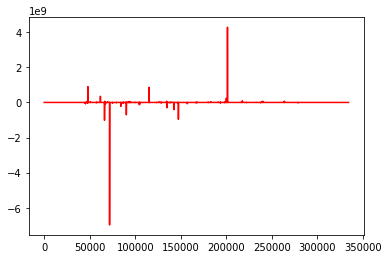

In [ ]:
for i, path_to_mp3_file in enumerate(list_mp3_files[1:2]):

    # load mp3 sound to array
    loaded_sound = AudioSegment.from_mp3(path_to_mp3_file)
    array_sound = np.array(loaded_sound.get_array_of_samples(), np.float64)

    # normalize array
    mean = np.mean(array_sound, axis=0)
    std = np.std(array_sound)
    array_sound -= mean
    array_sound /= std

    # add random noise
    max_1 = max(array_sound)
    noise = np.random.normal(0, 0.75, len(array_sound))
    array_sound_noisy = np.add(noise, array_sound)
    max_2 = max(array_sound_noisy)
    array_sound_noisy *= max_1/max_2
    
    # # save original to wav
    # array_sound_noisy_to_save = array_sound_noisy * std
    # array_sound_noisy_to_save += mean
    # array_sound_noisy_to_save = np.array(array_sound_noisy_to_save, np.int16)
    # path_to_wav_file = './noised/noised_sound0.wav'
    # write(path_to_wav_file, 48000, array_sound_noisy_to_save)

    # denoised = np.where(np.sqrt(array_sound_noisy**2-array_sound**2)>array_sound_noisy/3, 0, array_sound_noisy)
    # mask = np.where(0<=(array_sound**2)/(noise**2),(array_sound**2)/(noise**2), 0)
    # mask = np.where(mask<1,mask, 1)
    mask = (array_sound**2)/(noise**2)

    denoised = array_sound_noisy * mask

    # plot original and noisy
    # plt.plot([i for i  in range(len(noise))], noise, 'r')
    # plt.plot([i for i  in range(len(array_sound))], array_sound, 'b')
    # plt.plot([50000+i for i  in range(1000)], mask[50000:51000], 'r')
    plt.plot([i for i  in range(len(denoised))], denoised, 'r')
    plt.show()

    # save reconverted sound to wav
    path_to_wav_file = './denoised/denoised_sound0.wav'
    write(path_to_wav_file, 48000, denoised)

    # # convert sound to to F_T_space
    # f, t, array_stft = stft(array_sound_noisy, fs=48000, nperseg=1000)
    # array_abs_stft = np.abs(array_stft)

    # plt.pcolormesh(t, f, array_abs_stft)
    # plt.title('STFT Magnitude')
    # plt.ylabel('Frequency [Hz]')
    # plt.xlabel('Time [sec]')
    # plt.show()

    # # convert back to sound from F_T_space
    # t, desnoised_array_sound = istft(array_stft, fs=48000, nperseg=1000)
    # desnoised_array_sound = np.array(desnoised_array_sound)
    # desnoised_array_sound *= std
    # desnoised_array_sound += mean
    # desnoised_array_sound = np.array(desnoised_array_sound, np.int16)

    # # save reconverted sound to wav
    # path_to_wav_file = './denoised/denoised_sound' + str(i) + '.wav'
    # write(path_to_wav_file, 48000, desnoised_array_sound)
    

In [ ]:
for path_to_mp3_file in tqdm(train_mp3_data):
    # print(i)
    a =1



100%|██████████| 500/500 [00:00<00:00, 310643.16it/s]


In [ ]:

samples, labels, mean, std = load_and_convert_data_with_label(list_mp3_files[1:2])

print(np.shape(samples))
print(np.shape(labels))

desnoised_array_stft = samples[0]*labels[0]

# convert back to sound from F_T_space
t, desnoised_array_sound = istft(desnoised_array_stft, fs=48000, nperseg=1000)
desnoised_array_sound = np.array(desnoised_array_sound)
desnoised_array_sound *= std
desnoised_array_sound += mean
desnoised_array_sound = np.array(desnoised_array_sound, np.int16)

# save reconverted sound to wav
path_to_wav_file = './denoised/denoised_sound0.wav'
write(path_to_wav_file, 48000, desnoised_array_sound)




(1, 501, 2000)
(1, 501, 2000)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater


In [ ]:
a = np.array([ 1 + 1j, 1 + 1j, 1 + 1j])
b = np.abs(a)
c = np.imag(a)
d = b + 1j*c
print(d)

[1.41421356+1.j 1.41421356+1.j 1.41421356+1.j]


In [ ]:
def num_conversion(x):
    x = np.uint16(x)
    result = []
    if x < 0:
        x = 0
    if x >= 65024:
        x = 65024
    if 0 <= x <= 65024:
        x_0 = x - x % 1000
        x_1 = x - x_0 - x % 10
        result = [x_0//1000, x_1//10]
    else:
        print("error, wrong input")
        print(x)
    return result

def im_conversion(im):
    im = np.array(im, np.int16)
    s = np.shape(im)
    s = [s[0], s[1], 2]
    result = np.zeros(s)
    for i in range(s[0]):
        for j in range(s[1]):
            result[i, j] = num_conversion(im[i, j])
    return np.uint16(result)

In [ ]:
def num_conversion_back(x_0, x_1):
    number = np.uint16(x_0*1000 + x_1*10) 
    return number
    
def im_conversion_back(im_0, im_1):
    im_0 = np.array(im_0, np.int16)
    im_1 = np.array(im_1, np.int16)
    s = np.shape(im_0)
    s = [s[0], s[1]]
    result = np.zeros(s)
    for i in range(s[0]):
        for j in range(s[1]):
            result[i, j] = num_conversion_back(im_0[i, j], im_1[i, j])
    return np.uint16(result)

## **TEST2**

In [15]:
# arr = np.zeros((501, 1000))
arr = np.array([range(10) for i in range(5)])
arr = np.expand_dims(arr, axis=0)

model = tf.keras.Sequential()
model.add(layers.Flatten(input_shape=(None, 501, 1000)))
model.compile()

pred = model(arr)
print(np.shape(pred))
print(pred)

(1, 50)
tf.Tensor(
[[0. 1. 2. 3. 4. 5. 6. 7. 8. 9. 0. 1. 2. 3. 4. 5. 6. 7. 8. 9. 0. 1. 2. 3.
  4. 5. 6. 7. 8. 9. 0. 1. 2. 3. 4. 5. 6. 7. 8. 9. 0. 1. 2. 3. 4. 5. 6. 7.
  8. 9.]], shape=(1, 50), dtype=float32)


In [59]:
def build_model():

    model = models.Sequential()
    model.add(layers.Conv1D(501, 10, activation='relu', padding='same', input_shape=(1000, 501)))
    # model.add(layers.MaxPool1D(2, padding='same'))
    model.add(layers.Conv1D(501, 10, activation='relu', padding='same'))
    # model.add(layers.MaxPool1D(2, padding='same'))
    model.add(layers.LSTM(501, return_sequences=True))
    # model.add(layers.UpSampling1D(4))

    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

    return model

model = build_model()
model.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_40 (Conv1D)           (None, 1000, 501)         2510511   
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 1000, 501)         2510511   
_________________________________________________________________
lstm_13 (LSTM)               (None, 1000, 501)         2010012   
Total params: 7,031,034
Trainable params: 7,031,034
Non-trainable params: 0
_________________________________________________________________


In [45]:
arr = np.zeros((1000, 501))
arr = np.expand_dims(arr, axis=0)

model = build_model()

pred = model(arr)
print(np.shape(pred))
# print(pred)

(1, 501)
